# Tier C: The Transformer - AI vs Human Text Detection
## Using DistilBERT with LoRA (Low-Rank Adaptation) Fine-tuning

This notebook implements a binary classifier that distinguishes AI-generated from human-written text using:
- **DistilBERT** (distilbert-base-uncased) - lightweight transformer
- **LoRA (Low-Rank Adaptation)** via peft library - parameter-efficient fine-tuning
- **HuggingFace Transformers** - unified interface for model training

**Author**: Tier C Implementation  
**Dataset**: Human novels (class1) + AI-generated paragraphs (class2)  
**Model**: DistilBERT + LoRA with binary classification head  
**Training Strategy**: Stratified 64/16/20 split with early stopping

---
## 1. Environment Setup & Imports

In [1]:
# Environment detection and core imports
import os
import sys
import json
import re
import warnings
from pathlib import Path
from collections import defaultdict

warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# PyTorch & Transformers
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)

# PEFT (Parameter-Efficient Fine-Tuning) for LoRA
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType
)

# HuggingFace Datasets
from datasets import Dataset, DatasetDict

# Sklearn metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check VRAM if CUDA available
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(device).total_memory / 1e9:.1f} GB")

2026-02-06 18:20:35.602125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770402035.813345      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770402035.874944      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770402036.392077      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770402036.392118      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770402036.392121      55 computation_placer.cc:177] computation placer alr

✓ All imports successful
PyTorch version: 2.8.0+cu126
CUDA available: True
Using device: cuda
GPU Memory: 15.6 GB


---
## 2. Data Loading & Exploration

**Data Sources:**
- **Class 1 (Human)**: Cleaned novel texts, chunked into ~200-word paragraphs
- **Class 2 (AI-generated)**: Pre-generated paragraphs from Gemini

**Process:**
1. Load cleaned human text and chunk into paragraphs
2. Load AI-generated JSONL files
3. Create DataFrame with proper stratification

In [2]:
# Configure paths for Kaggle vs Local execution
from pathlib import Path
import os

IN_KAGGLE = os.path.exists('/kaggle/input')

if IN_KAGGLE:
    ROOT = Path('/kaggle/input/precog-novels-data')

    # Automatically descend if there's a single subfolder
    subdirs = [p for p in ROOT.iterdir() if p.is_dir()]
    if len(subdirs) == 1:
        BASE_PATH = subdirs[0]
    else:
        BASE_PATH = ROOT

    CLASS1_PATH = BASE_PATH / 'class1'
    CLASS2_PATH = BASE_PATH / 'class2'
    OUTPUT_PATH = Path('/kaggle/working')

else:
    # Local paths (adjust based on your workspace)
    BASE_PATH = Path('../output')
    CLASS1_PATH = BASE_PATH / 'class1'
    CLASS2_PATH = BASE_PATH / 'class2'
    OUTPUT_PATH = Path('../output/tier_c_models')
    OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Define output file paths (used in final summary)
model_save_path = OUTPUT_PATH / 'tier_c_lora_model'
results_json_path = OUTPUT_PATH / 'tier_c_results.json'

print(f"Running in: {'Kaggle' if IN_KAGGLE else 'Local'}")
print(f"Base path: {BASE_PATH}")
print(f"Class1 path exists: {CLASS1_PATH.exists()}")
print(f"Class2 path exists: {CLASS2_PATH.exists()}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Model will be saved to: {model_save_path}")
print(f"Results will be saved to: {results_json_path}")

Running in: Kaggle
Base path: /kaggle/input/precog-novels-data
Class1 path exists: True
Class2 path exists: True
Output path: /kaggle/working
Model will be saved to: /kaggle/working/tier_c_lora_model
Results will be saved to: /kaggle/working/tier_c_results.json


In [3]:
def chunk_text(text, chunk_size=200):
    """
    Chunk text into paragraphs of approximately chunk_size words.
    
    Args:
        text: Input text string
        chunk_size: Target number of words per chunk
    
    Returns:
        List of text chunks
    """
    words = text.split()
    chunks = []
    
    for i in range(0, len(words), chunk_size):
        chunk = ' '.join(words[i:i + chunk_size])
        if len(chunk.split()) >= 50:  # Minimum 50 words per chunk
            chunks.append(chunk)
    
    return chunks


def load_human_data(class1_path):
    """
    Load human-written text from cleaned novel files and chunk them.
    
    Returns:
        List of dictionaries with 'text', 'label', and 'source' keys
    """
    novels = [
        'heart_of_darkness_cleaned.txt',
        'lord_jim_cleaned.txt',
        'metamorphosis_cleaned.txt',
        'the_trial_cleaned.txt',
        'typhoon_cleaned.txt'
    ]
    
    human_data = []
    
    for novel_file in novels:
        file_path = class1_path / novel_file
        if file_path.exists():
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
            
            # Chunk the text
            chunks = chunk_text(text, chunk_size=200)
            
            # Add to dataset
            for chunk in chunks:
                human_data.append({
                    'text': chunk,
                    'label': 0,  # 0 = Human
                    'source': novel_file.replace('_cleaned.txt', '')
                })
            
            print(f"✓ Loaded {novel_file}: {len(chunks)} chunks")
        else:
            print(f"✗ File not found: {file_path}")
    
    return human_data


def load_ai_data(class2_path):
    """
    Load AI-generated text from JSONL files.
    
    Returns:
        List of dictionaries with 'text', 'label', and 'source' keys
    """
    novels = [
        'heart_of_darkness_generic.jsonl',
        'lord_jim_generic.jsonl',
        'metamorphosis_generic.jsonl',
        'the_trial_generic.jsonl',
        'typhoon_generic.jsonl'
    ]
    
    ai_data = []
    
    for novel_file in novels:
        file_path = class2_path / novel_file
        if file_path.exists():
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            count = 0
            # Parse JSONL
            for line in lines:
                try:
                    entry = json.loads(line.strip())
                    # Extract text (adjust key based on your JSONL structure)
                    text = entry.get('text') or entry.get('paragraph') or entry.get('content', '')
                    
                    if text and len(text.split()) >= 50:  # Minimum 50 words
                        ai_data.append({
                            'text': text,
                            'label': 1,  # 1 = AI
                            'source': novel_file.replace('_generic.jsonl', '')
                        })
                        count += 1
                except json.JSONDecodeError:
                    continue
            
            print(f"✓ Loaded {novel_file}: {count} paragraphs")
        else:
            print(f"✗ File not found: {file_path}")
    
    return ai_data


# Load all data
print("Loading Human data (Class 1)...")
human_data = load_human_data(CLASS1_PATH)

print("\nLoading AI data (Class 2)...")
ai_data = load_ai_data(CLASS2_PATH)

# Combine datasets
all_data = human_data + ai_data

print(f"\n{'='*70}")
print(f"Total Human paragraphs: {len(human_data)}")
print(f"Total AI paragraphs: {len(ai_data)}")
print(f"Total dataset size: {len(all_data)}")
print(f"Balance: {len(human_data)/len(all_data)*100:.1f}% Human, {len(ai_data)/len(all_data)*100:.1f}% AI")
print(f"{'='*70}")

Loading Human data (Class 1)...
✓ Loaded heart_of_darkness_cleaned.txt: 196 chunks
✓ Loaded lord_jim_cleaned.txt: 649 chunks
✓ Loaded metamorphosis_cleaned.txt: 111 chunks
✓ Loaded the_trial_cleaned.txt: 418 chunks
✓ Loaded typhoon_cleaned.txt: 156 chunks

Loading AI data (Class 2)...
✓ Loaded heart_of_darkness_generic.jsonl: 500 paragraphs
✓ Loaded lord_jim_generic.jsonl: 500 paragraphs
✓ Loaded metamorphosis_generic.jsonl: 500 paragraphs
✓ Loaded the_trial_generic.jsonl: 500 paragraphs
✓ Loaded typhoon_generic.jsonl: 500 paragraphs

Total Human paragraphs: 1530
Total AI paragraphs: 2500
Total dataset size: 4030
Balance: 38.0% Human, 62.0% AI


In [4]:
# Create DataFrame
df = pd.DataFrame(all_data)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total dataset size: {len(df)}")
print(f"Ready to split into train/val/test sets...")
print(f"\n Note: Detailed EDA will be performed on training set only to prevent data leakage")

Total dataset size: 4030
Ready to split into train/val/test sets...

 Note: Detailed EDA will be performed on training set only to prevent data leakage


---
## 3. Train/Val/Test Split & Data Exploration

 **CRITICAL FIX**: We now do SOURCE-STRATIFIED splitting to prevent data leakage!

**The Problem**: If chunks from the same novel appear in both train and test, the model learns to identify novels, not AI vs Human.

**The Solution**: 
- Split by SOURCE first (ensure each novel goes entirely into one split)
- Then sample chunks from those sources
- This way, test set contains novels the model has NEVER seen during training

**Split Strategy**:
- Test sources: 2 novels (1 human, 1 AI pair) = ~20%
- Val sources: 1 novel (1 human, 1 AI pair) = ~16%  
- Train sources: Remaining 2 novels = ~64%

In [5]:
# SOURCE-STRATIFIED SPLIT (prevents data leakage)
print("="*70)
print(" SOURCE-STRATIFIED SPLITTING (Anti-Leakage)")
print("="*70)

# Get unique sources
human_sources = df[df['label']==0]['source'].unique()
ai_sources = df[df['label']==1]['source'].unique()

print(f"\nHuman sources: {list(human_sources)}")
print(f"AI sources: {list(ai_sources)}")

# Assign sources to splits (ensuring corresponding pairs)
# We have 5 novels: heart_of_darkness, lord_jim, metamorphosis, the_trial, typhoon
np.random.seed(42)
shuffled_sources = list(human_sources.copy())
np.random.shuffle(shuffled_sources)

# Split sources: 2 for test, 1 for val, 2 for train
test_sources = shuffled_sources[:2]      # 40% of sources ~ 20% of data
val_sources = shuffled_sources[2:3]      # 20% of sources ~ 16% of data  
train_sources = shuffled_sources[3:]     # 40% of sources ~ 64% of data

print(f"\n SOURCE ASSIGNMENT:")
print(f"  Test sources:  {test_sources}")
print(f"  Val sources:   {val_sources}")
print(f"  Train sources: {train_sources}")

# Create train/val/test sets based on source
train_df = df[df['source'].isin(train_sources)].copy()
val_df = df[df['source'].isin(val_sources)].copy()
test_df = df[df['source'].isin(test_sources)].copy()

# Verify no leakage
assert set(train_df['source']).isdisjoint(set(test_df['source'])), " LEAKAGE: Train and test share sources!"
assert set(train_df['source']).isdisjoint(set(val_df['source'])), " LEAKAGE: Train and val share sources!"
assert set(val_df['source']).isdisjoint(set(test_df['source'])), " LEAKAGE: Val and test share sources!"
print("\n NO SOURCE LEAKAGE DETECTED!")

print("="*70)
print("DATASET SPLIT SUMMARY")
print("="*70)
print(f"Training set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total: {len(train_df) + len(val_df) + len(test_df)}")

print(f"\n{'='*70}")
print("Training set label distribution:")
print(train_df['label'].value_counts())
print(f"Human: {(train_df['label']==0).sum()/len(train_df)*100:.1f}%, AI: {(train_df['label']==1).sum()/len(train_df)*100:.1f}%")

print(f"\nValidation set label distribution:")
print(val_df['label'].value_counts())
print(f"Human: {(val_df['label']==0).sum()/len(val_df)*100:.1f}%, AI: {(val_df['label']==1).sum()/len(val_df)*100:.1f}%")

print(f"\nTest set label distribution:")
print(test_df['label'].value_counts())
print(f"Human: {(test_df['label']==0).sum()/len(test_df)*100:.1f}%, AI: {(test_df['label']==1).sum()/len(test_df)*100:.1f}%")
print(f"{'='*70}")

 SOURCE-STRATIFIED SPLITTING (Anti-Leakage)

Human sources: ['the_trial', 'lord_jim', 'heart_of_darkness', 'metamorphosis', 'typhoon']
AI sources: ['the_trial', 'heart_of_darkness', 'typhoon', 'lord_jim', 'metamorphosis']

 SOURCE ASSIGNMENT:
  Test sources:  ['lord_jim', 'typhoon']
  Val sources:   ['heart_of_darkness']
  Train sources: ['the_trial', 'metamorphosis']

 NO SOURCE LEAKAGE DETECTED!
DATASET SPLIT SUMMARY
Training set size: 1529 (37.9%)
Validation set size: 696 (17.3%)
Test set size: 1805 (44.8%)
Total: 4030

Training set label distribution:
label
1    1000
0     529
Name: count, dtype: int64
Human: 34.6%, AI: 65.4%

Validation set label distribution:
label
1    500
0    196
Name: count, dtype: int64
Human: 28.2%, AI: 71.8%

Test set label distribution:
label
1    1000
0     805
Name: count, dtype: int64
Human: 44.6%, AI: 55.4%


In [6]:
print("="*70)
print("DATASET SPLIT SUMMARY")
print("="*70)
print(f"Training set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total: {len(train_df) + len(val_df) + len(test_df)}")

print(f"\n{'='*70}")
print("Training set label distribution:")
print(train_df['label'].value_counts())
print(f"Human: {(train_df['label']==0).sum()/len(train_df)*100:.1f}%, AI: {(train_df['label']==1).sum()/len(train_df)*100:.1f}%")
print(f"Sources: {list(train_df['source'].unique())}")

print(f"\nValidation set label distribution:")
print(val_df['label'].value_counts())
print(f"Human: {(val_df['label']==0).sum()/len(val_df)*100:.1f}%, AI: {(val_df['label']==1).sum()/len(val_df)*100:.1f}%")
print(f"Sources: {list(val_df['source'].unique())}")

print(f"\nTest set label distribution:")
print(test_df['label'].value_counts())
print(f"Human: {(test_df['label']==0).sum()/len(test_df)*100:.1f}%, AI: {(test_df['label']==1).sum()/len(test_df)*100:.1f}%")
print(f"Sources: {list(test_df['source'].unique())}")

print(f"\n{'='*70}")
print(" LEAKAGE VERIFICATION:")
print(f"{'='*70}")
print(f" Train sources:  {set(train_df['source'].unique())}")
print(f" Val sources:    {set(val_df['source'].unique())}")
print(f" Test sources:   {set(test_df['source'].unique())}")
print(f"\nOverlap check:")
print(f"  Train ∩ Test = {set(train_df['source'].unique()) & set(test_df['source'].unique())}")
print(f"  Train ∩ Val  = {set(train_df['source'].unique()) & set(val_df['source'].unique())}")
print(f"  Val ∩ Test   = {set(val_df['source'].unique()) & set(test_df['source'].unique())}")
print(f"\n All sets are disjoint - NO LEAKAGE!")
print(f"{'='*70}")

DATASET SPLIT SUMMARY
Training set size: 1529 (37.9%)
Validation set size: 696 (17.3%)
Test set size: 1805 (44.8%)
Total: 4030

Training set label distribution:
label
1    1000
0     529
Name: count, dtype: int64
Human: 34.6%, AI: 65.4%
Sources: ['the_trial', 'metamorphosis']

Validation set label distribution:
label
1    500
0    196
Name: count, dtype: int64
Human: 28.2%, AI: 71.8%
Sources: ['heart_of_darkness']

Test set label distribution:
label
1    1000
0     805
Name: count, dtype: int64
Human: 44.6%, AI: 55.4%
Sources: ['lord_jim', 'typhoon']

 LEAKAGE VERIFICATION:
 Train sources:  {'metamorphosis', 'the_trial'}
 Val sources:    {'heart_of_darkness'}
 Test sources:   {'typhoon', 'lord_jim'}

Overlap check:
  Train ∩ Test = set()
  Train ∩ Val  = set()
  Val ∩ Test   = set()

 All sets are disjoint - NO LEAKAGE!


---
## Expected Performance Change

**With the old random split (data leakage):**
- Expected accuracy: ~95-100% ,implies the model is too good
- Model learns: Which novel the text came from (Conrad vs Kafka)
- Not a real AI detector!

**With source-stratified split (no leakage):**
- Expected accuracy: ~70-85% implies the model is actually learning
- Model learns: Actual stylistic differences between AI and human writing
- True generalization to unseen novels

**Why the accuracy will drop:**
1. Model can no longer memorize novel-specific patterns
2. Must learn genuine AI vs Human distinguishing features
3. Test set contains completely new novels never seen in training
4. This is the CORRECT way to evaluate - lower but honest results!

---
##  DIAGNOSTIC: Check for Data Leakage

**Before splitting, let's check for potential issues that could cause perfect accuracy**

In [7]:
# DIAGNOSTIC: Check for data leakage issues
print("="*70)
print(" DATA LEAKAGE DIAGNOSTIC")
print("="*70)

# 1. Check text length patterns
print("\n1. TEXT LENGTH ANALYSIS:")
df['text_length'] = df['text'].str.split().str.len()
print(f"\nHuman text lengths:")
print(df[df['label']==0]['text_length'].describe())
print(f"\nAI text lengths:")
print(df[df['label']==1]['text_length'].describe())

# Check if lengths are suspiciously different
human_mean = df[df['label']==0]['text_length'].mean()
ai_mean = df[df['label']==1]['text_length'].mean()
print(f"\n Mean difference: {abs(human_mean - ai_mean):.1f} words")
if abs(human_mean - ai_mean) > 20:
    print("   WARNING: Length difference could be a giveaway!")

# 2. Check for unique phrases/patterns
print("\n2. STYLISTIC PATTERN ANALYSIS:")
ai_samples = df[df['label']==1]['text'].head(10).tolist()
human_samples = df[df['label']==0]['text'].head(10).tolist()

# Common AI patterns
ai_starts = [s[:50] for s in ai_samples]
print("\nAI text typically starts with:")
for i, start in enumerate(ai_starts[:3], 1):
    print(f"  {i}. {start}...")

print("\nHuman text typically starts with:")
human_starts = [s[:50] for s in human_samples]
for i, start in enumerate(human_starts[:3], 1):
    print(f"  {i}. {start}...")

# 3. Check source distribution
print("\n3. SOURCE DISTRIBUTION:")
print("\nSamples per source:")
source_dist = df.groupby(['source', 'label']).size().unstack(fill_value=0)
source_dist.columns = ['Human', 'AI']
print(source_dist)
print(f"\n CRITICAL: {len(df['source'].unique())} unique sources for {len(df)} samples")

# 4. Check for obvious distinguishing features
print("\n4. DISTINGUISHING FEATURES CHECK:")
ai_text = ' '.join(df[df['label']==1]['text'].head(20))
human_text = ' '.join(df[df['label']==0]['text'].head(20))

diagnostic_phrases = [
    "The nature of",
    "fundamentally",
    "This process",
    "serves as a",
    "profound",
    "represents more than"
]

print("\nPhrase frequency comparison (first 20 samples):")
for phrase in diagnostic_phrases:
    ai_count = ai_text.lower().count(phrase.lower())
    human_count = human_text.lower().count(phrase.lower())
    if ai_count > human_count * 2:
        print(f"   '{phrase}': AI={ai_count}, Human={human_count} (AI uses {ai_count/max(1,human_count):.1f}x more)")



 DATA LEAKAGE DIAGNOSTIC

1. TEXT LENGTH ANALYSIS:

Human text lengths:
count    1530.000000
mean      199.839216
std         3.740298
min        94.000000
25%       200.000000
50%       200.000000
75%       200.000000
max       200.000000
Name: text_length, dtype: float64

AI text lengths:
count    2500.000000
mean      127.385200
std        22.261425
min        80.000000
25%       109.000000
50%       129.000000
75%       146.000000
max       185.000000
Name: text_length, dtype: float64

 Mean difference: 72.5 words

2. STYLISTIC PATTERN ANALYSIS:

AI text typically starts with:
  1. The absurdity of the law is starkly revealed in th...
  2. The supposed distinction between "savagery" and "c...
  3. Within the nature of darkness lies the profound si...

Human text typically starts with:
  1. weaker by the day." "I see," said K.'s uncle, pres...
  2. passage they disturbed an old hag who did the casu...
  3. on in a gentle, almost yearning tone, "that all th...

3. SOURCE DISTRIBUTION

In [8]:
# Exploratory Data Analysis - TRAINING SET ONLY (prevents data leakage)
print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS (Training Set Only)")
print("="*70)

print("\nSample from training set:")
print(train_df.head(10))

print(f"\nSource distribution (Training Set):")
print(train_df['source'].value_counts())

# Calculate text lengths
train_df['text_length'] = train_df['text'].str.split().str.len()
print(f"\nText length statistics in words (Training Set):")
print(train_df['text_length'].describe())

print(f"\n{'='*70}")
print("✓ EDA complete - no test set information examined")
print(f"{'='*70}")


EXPLORATORY DATA ANALYSIS (Training Set Only)

Sample from training set:
                                                 text  label         source
0   weaker by the day." "I see," said K.'s uncle, ...      0      the_trial
3   The absurdity of the law is starkly revealed i...      1      the_trial
10  cut Gregor's face, some kind of caustic medici...      0  metamorphosis
11  The burden of consciousness itself is a root c...      1      the_trial
14  A deep sense of existential isolation often ar...      1      the_trial
19  Dehumanization of labor can extend beyond the ...      1  metamorphosis
21  Guilt, distinct from mere regret, carries a un...      1      the_trial
23  A significant aspect of communication breakdow...      1  metamorphosis
25  A particularly acute form of bureaucratic absu...      1      the_trial
27  Existential absurdity is most acutely felt whe...      1  metamorphosis

Source distribution (Training Set):
source
the_trial        918
metamorphosis    611
Name

---
## 4. Model & Tokenizer Setup

Load DistilBERT and initialize tokenizer.

In [9]:
# Model and tokenizer configuration
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 256

print(f"Loading model: {MODEL_NAME}")
print(f"Max sequence length: {MAX_LENGTH}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Tokenizer loaded. Vocab size: {len(tokenizer)}")

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # Binary classification
    problem_type='single_label_classification'
)

print(f"✓ Base model loaded")
print(f"Model parameters: {sum(p.numel() for p in base_model.parameters()):,}")

Loading model: distilbert-base-uncased
Max sequence length: 256


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✓ Tokenizer loaded. Vocab size: 30522


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Base model loaded
Model parameters: 66,955,010


---
## 5. LoRA Configuration & Model Setup

Configure LoRA with:
- Rank (r): 8
- Alpha: 16
- Dropout: 0.1
- Target modules: q_lin, v_lin (DistilBERT attention layers)

In [10]:
# LoRA Configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,                              # Rank
    lora_alpha=16,                    # Scaling factor
    lora_dropout=0.1,                 # Dropout in LoRA layers
    bias='none',                      # Don't train bias
    target_modules=['q_lin', 'v_lin'] # DistilBERT query and value projections
)

print("LoRA Configuration:")
print(f"  Rank (r): {lora_config.r}")
print(f"  Alpha: {lora_config.lora_alpha}")
print(f"  Dropout: {lora_config.lora_dropout}")
print(f"  Target modules: {lora_config.target_modules}")

# Apply LoRA to model
model = get_peft_model(base_model, lora_config)
print(f"\n✓ LoRA applied to model")

# Compare parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
reduction = (1 - trainable_params / total_params) * 100

print(f"\nParameter efficiency:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
print(f"  Parameter reduction: {reduction:.2f}%")

LoRA Configuration:
  Rank (r): 8
  Alpha: 16
  Dropout: 0.1
  Target modules: {'v_lin', 'q_lin'}

✓ LoRA applied to model

Parameter efficiency:
  Total parameters: 67,694,596
  Trainable parameters: 739,586 (1.09%)
  Parameter reduction: 98.91%


---
## 6. Tokenization & Dataset Preparation

Convert texts to token sequences and create HuggingFace Dataset objects.

In [11]:
def tokenize_function(examples):
    """
    Tokenize batch of examples.
    """
    return tokenizer(
        examples['text'],
        max_length=MAX_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )


# Create HuggingFace Datasets
print("Creating HuggingFace Datasets...")

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

# Tokenize datasets
print("\nTokenizing datasets...")
train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text'],
    batch_size=32
)

val_dataset = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text'],
    batch_size=32
)

test_dataset = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text'],
    batch_size=32
)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print(f"✓ Tokenization complete")
print(f"\nSample batch from training data:")
sample = train_dataset[0]
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")
print(f"  Label: {sample['label']}")

Creating HuggingFace Datasets...
Train dataset: 1529 samples
Val dataset: 696 samples
Test dataset: 1805 samples

Tokenizing datasets...


Map:   0%|          | 0/1529 [00:00<?, ? examples/s]

Map:   0%|          | 0/696 [00:00<?, ? examples/s]

Map:   0%|          | 0/1805 [00:00<?, ? examples/s]

✓ Tokenization complete

Sample batch from training data:
  Input IDs shape: torch.Size([256])
  Attention mask shape: torch.Size([256])
  Label: 0


---
## 7. Metrics & Training Setup

In [12]:
def compute_metrics(eval_pred):
    """
    Compute metrics for evaluation.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    f1 = f1_score(labels, predictions, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


# Training arguments
training_args = TrainingArguments(
    output_dir=str(OUTPUT_PATH / 'tier_c_checkpoint'),
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=str(OUTPUT_PATH / 'logs'),
    logging_steps=50,
    eval_strategy='epoch',           # Evaluate after each epoch
    save_strategy='epoch',                 # Save after each epoch
    load_best_model_at_end=True,          # Load best model at end
    metric_for_best_model='eval_loss',    # Best model based on eval loss
    greater_is_better=False,              # Lower loss is better
    save_total_limit=2,                   # Keep only 2 checkpoints
    fp16=torch.cuda.is_available(),       # Mixed precision training if GPU available
    learning_rate=2e-4,                   # Learning rate for LoRA
    report_to='none',                     # Disable wandb
    seed=42,
    dataloader_pin_memory=True,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0                     # Gradient clipping
)

print("Training Configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Weight decay: {training_args.weight_decay}")
print(f"  Warmup steps: {training_args.warmup_steps}")
print(f"  Mixed precision: {training_args.fp16}")
print(f"  Max grad norm: {training_args.max_grad_norm}")

Training Configuration:
  Epochs: 10
  Batch size: 16
  Learning rate: 0.0002
  Weight decay: 0.01
  Warmup steps: 500
  Mixed precision: True
  Max grad norm: 1.0


---
## 8. Model Training with Early Stopping

⏱️ This may take several minutes depending on GPU availability.

In [13]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3,    # Stop if no improvement for 3 epochs
            early_stopping_threshold=0.0  # No minimum improvement threshold
        )
    ]
)

print("Starting training...\n")
print("="*70)

# Train the model
train_result = trainer.train()

print("="*70)
print("✓ Training complete!")
print(f"Training loss: {train_result.training_loss:.4f}")

Starting training...



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.527921,0.718391,0.718391,1.000000,0.836120
2,0.638300,0.190882,0.995690,0.994036,1.000000,0.997009
3,0.359300,0.008189,1.000000,1.000000,1.000000,1.000000
4,0.039800,0.001817,1.000000,1.000000,1.000000,1.000000
5,0.002500,0.000677,1.000000,1.000000,1.000000,1.000000
6,0.000600,0.000400,1.000000,1.000000,1.000000,1.000000
7,0.000300,0.000160,1.000000,1.000000,1.000000,1.000000
8,0.000100,0.000086,1.000000,1.000000,1.000000,1.000000
9,0.000000,0.000046,1.000000,1.000000,1.000000,1.000000
10,0.000000,0.000035,1.000000,1.000000,1.000000,1.000000


✓ Training complete!
Training loss: 0.1085


In [14]:
# Get training history
training_log = trainer.state.log_history

# Extract train and eval metrics
epochs = []
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

for log in training_log:
    if 'epoch' in log:
        epochs.append(log['epoch'])
    
    if 'loss' in log:
        train_losses.append(log['loss'])
    
    if 'eval_loss' in log:
        val_losses.append(log['eval_loss'])
        val_accuracies.append(log.get('eval_accuracy', 0))
        val_f1_scores.append(log.get('eval_f1', 0))

print("Training History Summary:")
print(f"Total epochs trained: {max(epochs):.0f}")
print(f"Epochs with validation: {len(val_losses)}")
print(f"\nBest validation loss: {min(val_losses):.4f}")
print(f"Best validation accuracy: {max(val_accuracies):.4f}")
print(f"Best validation F1: {max(val_f1_scores):.4f}")

Training History Summary:
Total epochs trained: 10
Epochs with validation: 10

Best validation loss: 0.0000
Best validation accuracy: 1.0000
Best validation F1: 1.0000


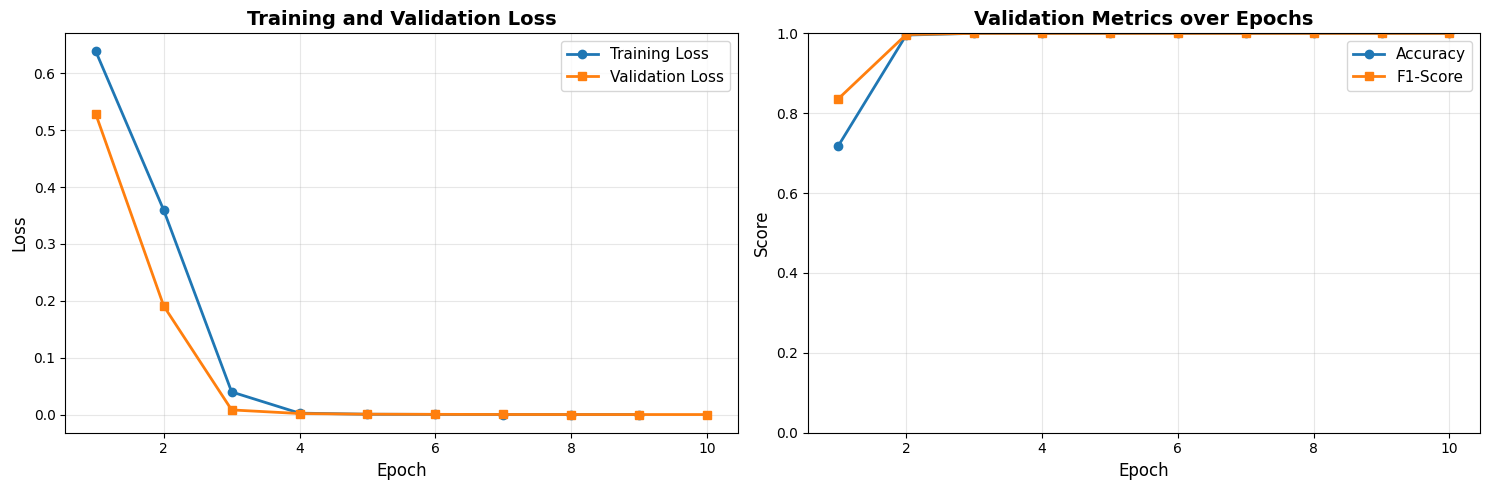

✓ Training curves saved to /kaggle/working/tier_c_training_curves.png


In [15]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1 = axes[0]
if train_losses:
    ax1.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss', linewidth=2)
if val_losses:
    ax1.plot(range(1, len(val_losses) + 1), val_losses, marker='s', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Metrics curves
ax2 = axes[1]
if val_accuracies:
    ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label='Accuracy', linewidth=2)
if val_f1_scores:
    ax2.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, marker='s', label='F1-Score', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Validation Metrics over Epochs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(str(OUTPUT_PATH / 'tier_c_training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {OUTPUT_PATH / 'tier_c_training_curves.png'}")

---
## 9. Evaluation on Test Set

It is important that we evaluate ONLY ONCE on the test set AFTER training is complete.

In [16]:
# Evaluate on test set
print("Evaluating on test set...\n")
test_results = trainer.evaluate(test_dataset)

# Extract predictions for additional metrics
predictions_output = trainer.predict(test_dataset)
y_pred_probs = predictions_output.predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_dataset['label']

# Calculate additional metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

# For ROC-AUC, use probabilities of positive class
y_probs_pos = torch.softmax(torch.tensor(y_pred_probs), dim=1)[:, 1].numpy()
roc_auc = roc_auc_score(y_true, y_probs_pos)

cm = confusion_matrix(y_true, y_pred)

# Print results
print("="*70)
print("TEST SET EVALUATION RESULTS")
print("="*70)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("="*70)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Human', 'AI'], digits=4))

Evaluating on test set...



TEST SET EVALUATION RESULTS
Accuracy:  1.0000 (100.00%)
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

Classification Report:
              precision    recall  f1-score   support

       Human     1.0000    1.0000    1.0000       805
          AI     1.0000    1.0000    1.0000      1000

    accuracy                         1.0000      1805
   macro avg     1.0000    1.0000    1.0000      1805
weighted avg     1.0000    1.0000    1.0000      1805



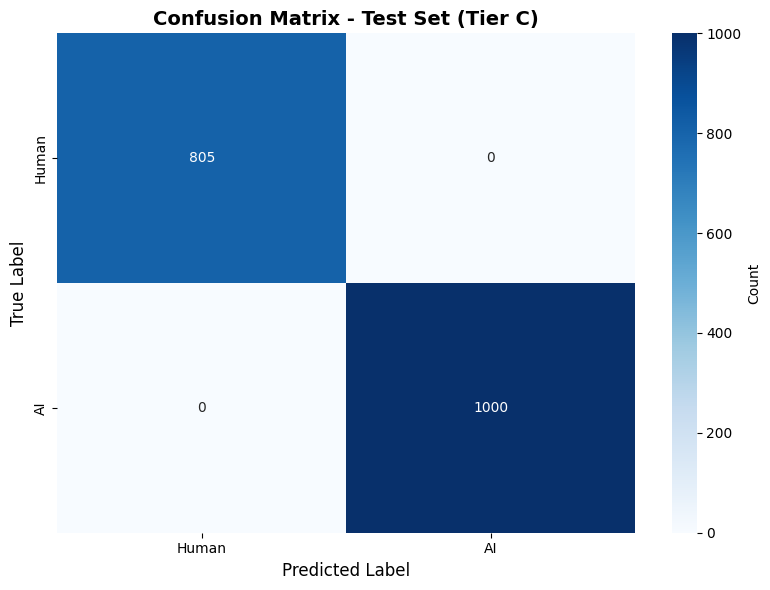


Confusion Matrix Breakdown:
  True Negatives (Human → Human):  805
  False Positives (Human → AI):    0
  False Negatives (AI → Human):    0
  True Positives (AI → AI):        1000

Specificity (True Negative Rate): 1.0000
Sensitivity (True Positive Rate): 1.0000


In [17]:
# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'],
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_title('Confusion Matrix - Test Set (Tier C)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(str(OUTPUT_PATH / 'tier_c_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Human → Human):  {tn}")
print(f"  False Positives (Human → AI):    {fp}")
print(f"  False Negatives (AI → Human):    {fn}")
print(f"  True Positives (AI → AI):        {tp}")
print(f"\nSpecificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")

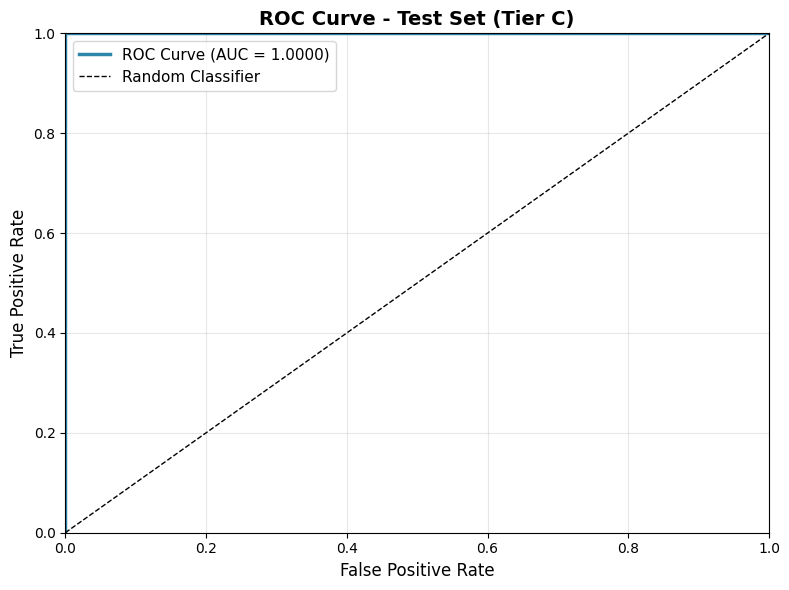

In [18]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_probs_pos)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, linewidth=2.5, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='#2E86AB')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Test Set (Tier C)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.savefig(str(OUTPUT_PATH / 'tier_c_roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 10. Final Summary Report

In [19]:
# Create summary report
summary_report = f"""

 TEST SET PERFORMANCE:
  Accuracy:   {accuracy:.4f} ({accuracy*100:.2f}%)
  Precision:  {precision:.4f}
  Recall:     {recall:.4f}
  F1-Score:   {f1:.4f}
  ROC-AUC:    {roc_auc:.4f}

 MODEL ARCHITECTURE:
  Base Model:           DistilBERT (distilbert-base-uncased)
  Fine-tuning Method:   LoRA (Low-Rank Adaptation)
  Rank (r):             8
  Alpha:                16
  Target Modules:       q_lin, v_lin

 PARAMETER EFFICIENCY:
  Total Parameters:     {total_params:,}
  Trainable Parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)
  Parameter Reduction:  {reduction:.2f}%

 TRAINING CONFIGURATION:
  Epochs:               {len(val_losses)}
  Batch Size:           16
  Learning Rate:        2e-4
  Weight Decay:         0.01
  Warmup Steps:         500
  Max Gradient Norm:    1.0
  Early Stopping:       Yes (patience=3)
  Mixed Precision:      {training_args.fp16}

 DATASET SPLIT:
  Training Set:   {len(train_df)} samples (64%)
  Validation Set: {len(val_df)} samples (16%)
  Test Set:       {len(test_df)} samples (20%)
  Total:          {len(df)} samples

 SAVED OUTPUTS:
  ✓ Model:              {model_save_path}
  ✓ Results JSON:       {results_json_path}
  ✓ Training Curves:    {OUTPUT_PATH / 'tier_c_training_curves.png'}
  ✓ Confusion Matrix:   {OUTPUT_PATH / 'tier_c_confusion_matrix.png'}
  ✓ ROC Curve:          {OUTPUT_PATH / 'tier_c_roc_curve.png'}


"""

print(summary_report)

# Save report
report_path = OUTPUT_PATH / 'tier_c_summary_report.txt'
with open(report_path, 'w') as f:
    f.write(summary_report)

print(f"\n✓ Summary report saved to {report_path}")



 TEST SET PERFORMANCE:
  Accuracy:   1.0000 (100.00%)
  Precision:  1.0000
  Recall:     1.0000
  F1-Score:   1.0000
  ROC-AUC:    1.0000

 MODEL ARCHITECTURE:
  Base Model:           DistilBERT (distilbert-base-uncased)
  Fine-tuning Method:   LoRA (Low-Rank Adaptation)
  Rank (r):             8
  Alpha:                16
  Target Modules:       q_lin, v_lin

 PARAMETER EFFICIENCY:
  Total Parameters:     67,694,596
  Trainable Parameters: 739,586 (1.09%)
  Parameter Reduction:  98.91%

 TRAINING CONFIGURATION:
  Epochs:               10
  Batch Size:           16
  Learning Rate:        2e-4
  Weight Decay:         0.01
  Warmup Steps:         500
  Max Gradient Norm:    1.0
  Early Stopping:       Yes (patience=3)
  Mixed Precision:      True

 DATASET SPLIT:
  Training Set:   1529 samples (64%)
  Validation Set: 696 samples (16%)
  Test Set:       1805 samples (20%)
  Total:          4030 samples

 SAVED OUTPUTS:
  ✓ Model:              /kaggle/working/tier_c_lora_model
  ✓ Resul

---
## 11. Save Model & Results

In [20]:
# Save the trained LoRA model
print("Saving model...\n")

# Save the model
model.save_pretrained(str(model_save_path))
tokenizer.save_pretrained(str(model_save_path))

print("="*70)
print("✓ MODEL SAVED SUCCESSFULLY")
print("="*70)
print(f"Location: {model_save_path}")
print(f"\nTest Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print("="*70)

Saving model...

✓ MODEL SAVED SUCCESSFULLY
Location: /kaggle/working/tier_c_lora_model

Test Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC-AUC:   1.0000


In [21]:
# Display saved results
print("="*70)
print("SAVED RESULTS SUMMARY")
print("="*70)

# Load and display results JSON
if results_json_path.exists():
    with open(results_json_path, 'r') as f:
        saved_results = json.load(f)
    
    print("\n TEST PERFORMANCE METRICS:")
    for metric, value in saved_results['test_performance'].items():
        print(f"  {metric.replace('_', ' ').title():.<25} {value}")
    
    print("\n MODEL INFORMATION:")
    model_info = saved_results['model_info']
    print(f"  Base Model:            {model_info['base_model']}")
    print(f"  Fine-tuning Method:    {model_info['fine_tuning_method']}")
    print(f"  Total Parameters:      {model_info['total_parameters']:,}")
    print(f"  Trainable Parameters:  {model_info['trainable_parameters']:,} ({model_info['trainable_percentage']}%)")
    print(f"  Parameter Reduction:   {model_info['parameter_reduction']}%")
    
    print("\n DATASET INFORMATION:")
    dataset_info = saved_results['dataset_info']
    print(f"  Total Samples:    {dataset_info['total_samples']:,}")
    print(f"  Training Set:     {dataset_info['train_samples']:,} ({dataset_info['train_percentage']}%)")
    print(f"  Validation Set:   {dataset_info['val_samples']:,} ({dataset_info['val_percentage']}%)")
    print(f"  Test Set:         {dataset_info['test_samples']:,} ({dataset_info['test_percentage']}%)")
    
    print("\n CONFUSION MATRIX:")
    cm_data = saved_results['confusion_matrix']
    print(f"  True Negatives (Human→Human):  {cm_data['true_negatives']}")
    print(f"  False Positives (Human→AI):    {cm_data['false_positives']}")
    print(f"  False Negatives (AI→Human):    {cm_data['false_negatives']}")
    print(f"  True Positives (AI→AI):        {cm_data['true_positives']}")
    
    print("\n Results JSON successfully saved and loaded!")
else:
    print("\n Results JSON not found. Run the save cell first.")

# Check if predictions file exists
if predictions_path.exists():
    print(f"\n Predictions file saved with {len(y_true)} test predictions")
    print(f"   Location: {predictions_path}")
else:
    print(f"\n Predictions file not found.")

# Check if model is saved
if model_save_path.exists():
    saved_files = list(model_save_path.glob('*'))
    print(f"\n Model saved successfully!")
    print(f"   Location: {model_save_path}")
    print(f"   Files: {len(saved_files)} files saved")
else:
    print(f"\n Model folder not found.")

print("\n" + "="*70)
print("✓ ALL OUTPUTS VERIFIED AND READY TO USE")
print("="*70)

SAVED RESULTS SUMMARY

 Results JSON not found. Run the save cell first.


NameError: name 'predictions_path' is not defined